# Texture-Based Optical Guided Despeckling of SAR Image

In [1]:
import os
# os.environ['JAX_PLATFORM_NAME'] = 'cpu'

import jax
import jax.numpy as jnp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Tuple, List
import time
import rasterio

from scripts.texture_descriptor import compute_texture_descriptor, rgb2gray, rgb2lab
from scripts.filters import gaussian_kernel_2d
from scripts.despeckling import UBF, DUBF
from scripts.utils import extract_patches, compute_indices_from_n_blocks
from scripts.despeckling import SARDespeckling

print(jax.devices())

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


[cuda(id=0)]


In [2]:
sar_despeckling = SARDespeckling()

### Load data

In [3]:
# opt = Image.open('/home/nus/Downloads/optical_sar_data/optical.png')
# sar = Image.open('/home/nus/Downloads/optical_sar_data/sar.png')

# opt_rgb = jnp.array(opt) / 255.0
# sar = jnp.array(sar) / 255.0
# sar = jnp.expand_dims(sar, axis=-1)  # (H, W, 1)

# opt_gray = rgb2gray(opt_rgb)
# opt_lab = rgb2lab(opt_rgb)

# print(sar.shape, opt_gray.shape, opt_lab.shape)

(500, 500, 3) (500, 500)


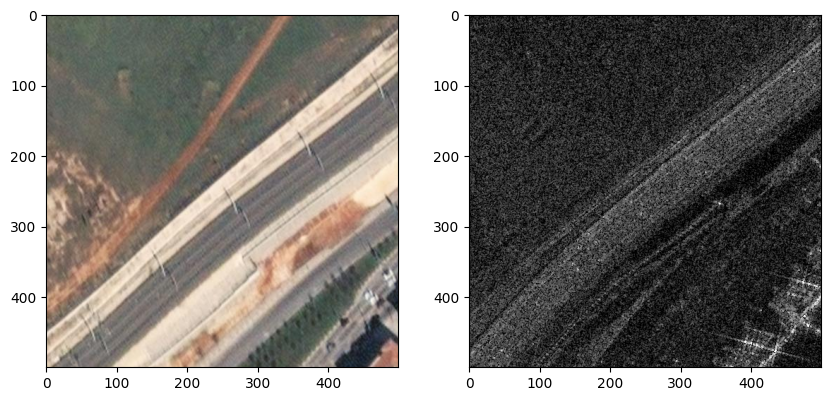

In [4]:
def crop(img: np.ndarray, x0: int, y0: int, size: int) -> np.ndarray:
    """Crop the image to the center with the given size."""
    return img[y0:y0+size, x0:x0+size]

path_opt = '/home/nus/workspace/datasets/spacenet9/train/02_optical_train_01.tif'
path_sar = '/home/nus/workspace/datasets/spacenet9/train/02_sar_train_01.tif'

with rasterio.open(path_opt) as src:
    r = src.read(1)
    g = src.read(2)
    b = src.read(3)
data_opt = np.dstack((r, g, b))

with rasterio.open(path_sar) as src:
    data_sar = src.read(1)

x_center_opt, y_center_opt = data_opt.shape[1] // 2, data_opt.shape[0] // 2
x_center_sar, y_center_sar = data_sar.shape[1] // 2, data_sar.shape[0] // 2

opt_coords = {
    'x0': x_center_opt - 500, 
    'y0': y_center_opt + 500, 
    'size': 500
}

sar_coords = {
    'x0': x_center_sar - 500, 
    'y0': y_center_sar + 300, 
    'size': 500
}

opt = crop(data_opt, **opt_coords)
sar = crop(data_sar, **sar_coords)

print(opt.shape, sar.shape)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(opt)
plt.subplot(1, 2, 2)
plt.imshow(sar, cmap='gray')

In [5]:
opt_rgb = jnp.array(opt) / 255.0
sar = jnp.array(sar) / 255.0
sar = jnp.expand_dims(sar, axis=-1)  # (H, W, 1)

opt_gray = rgb2gray(opt_rgb)
opt_lab = rgb2lab(opt_rgb)

print(sar.shape, opt_gray.shape, opt_lab.shape, opt_rgb.shape)

2025-08-18 12:10:27.802553: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.8 which is older than the ptxas CUDA version (12.9.86). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


(500, 500, 1) (500, 500, 1) (500, 500, 3) (500, 500, 3)


### Compute texture descriptor

In [6]:
params_texture_descriptor = {
    'img': opt_lab,
    'radius': 7
}

In [7]:
time_start = time.time()
S = compute_texture_descriptor(**params_texture_descriptor)
# replace nan with interpolation
S = jnp.nan_to_num(S, nan=0.0)
time_end = time.time()
print(f"{time_end - time_start:.4f} seconds")

7.3722 seconds


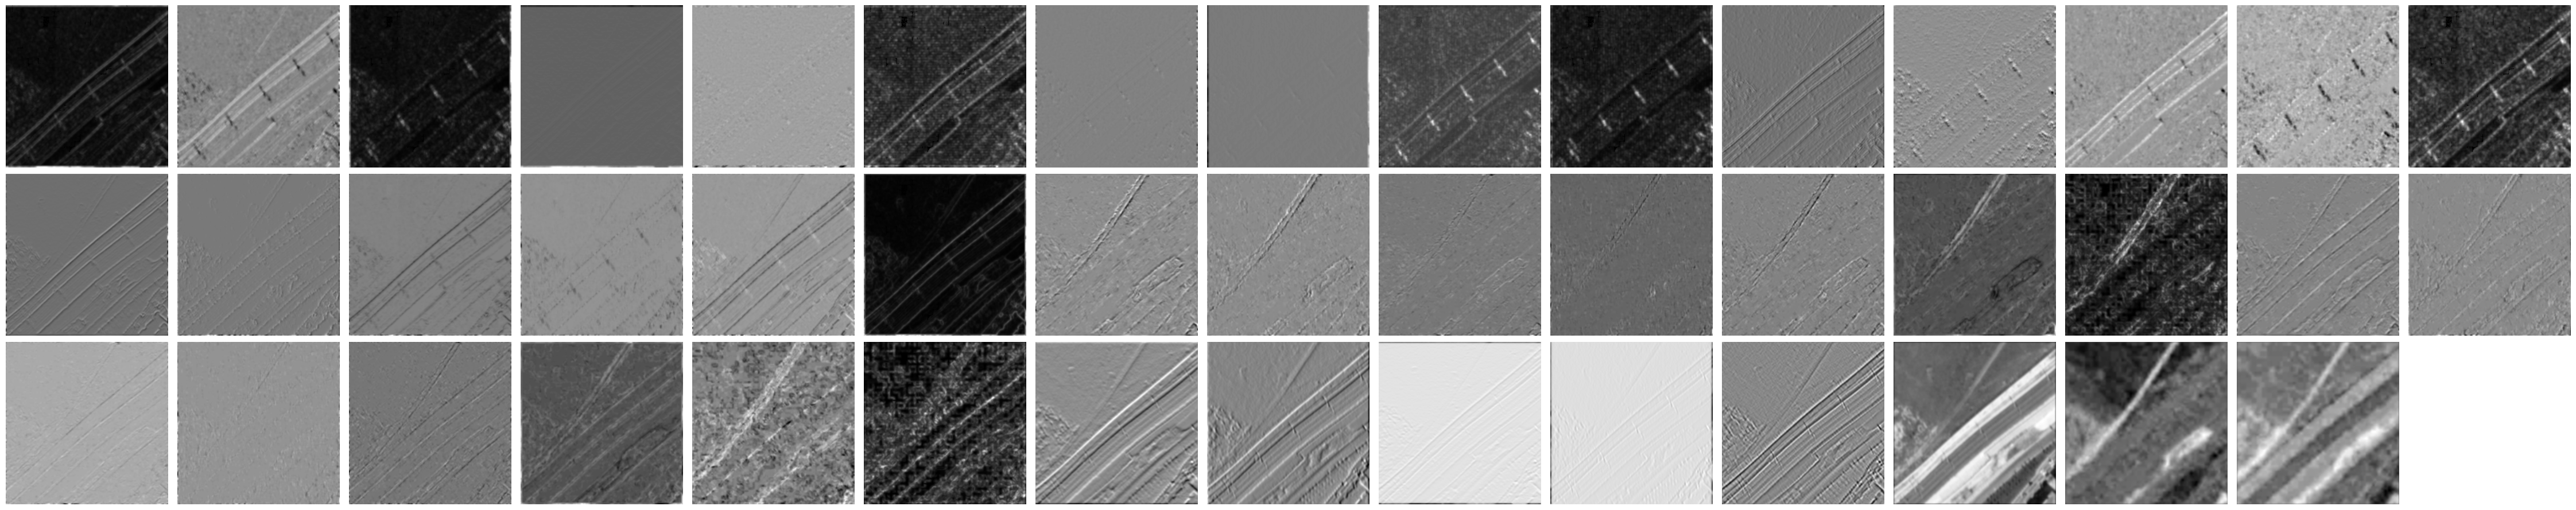

In [8]:
D = S.shape[-1]

N = 15  # Number of columns for plotting
plt.figure(figsize=(N * 3, (D // N + 1) * 3))
for i in range(D):
    plt.subplot(D // N + 1, N, i + 1)
    plt.imshow(S[:,:,i], cmap='gray')
    plt.axis('off')
plt.tight_layout()

In [9]:
S_ = sar_despeckling._step1_compute_texture_descriptor(opt=params_texture_descriptor['img'], radius=params_texture_descriptor['radius'])

error_on_desc = jnp.abs(S - S_).mean()
print(f"Error on texture descriptor: {error_on_desc:.16f}")

INFO:root:Computing texture descriptor...
INFO:root:Warning: NaN values found in texture descriptor. Replacing with zeros.
INFO:root:Texture descriptor computed in 0.11 seconds.


Error on texture descriptor: 0.0000000000000000


### UBF

In [10]:
# L = opt_gray

# ubf = UBF()
# time_start = time.time()
# S_ubf, error = ubf.filter(S, L, sigma_s=5, sigma_l=0.05, alpha_ubf=2, n_iter=30, n_blocks=2)
# time_end = time.time()
# print(f"{time_end - time_start:.4f} seconds")

In [11]:
# D = S_ubf.shape[-1]

# N = 5  # Number of columns for plotting
# plt.figure(figsize=(N * 3, (D // N + 1) * 3))
# for i in range(D):
#     plt.subplot(D // N + 1, N, i + 1)
#     plt.imshow(S_ubf[:,:,i], cmap='gray')
#     plt.axis('off')
# plt.tight_layout()

In [12]:
# plt.plot(error)
# plt.plot(np.arange(len(error)), np.zeros_like(error), 'k--')

### DUBF

In [ ]:
params_dubf = {
    'descriptor': S,
    'opt': opt_gray,
    'sar': sar,  # (H, W, 1)
    'sigma_spatial': 5,
    'sigma_luminance_opt': 0.01,
    'sigma_luminance_sar': 0.1,
    'alpha_update': 2,
    'n_iterations': 50,
    'n_blocks': 10
}

In [62]:
dubf = DUBF()
time_start = time.time()
S_dubf, error = dubf.filter(**params_dubf)
time_end = time.time()
print(f"{time_end - time_start:.4f} seconds")

DUBF Iterations:   0%|          | 0/30 [00:00<?, ?it/s]

DUBF Iterations: 100%|██████████| 30/30 [00:50<00:00,  1.68s/it]

50.3264 seconds


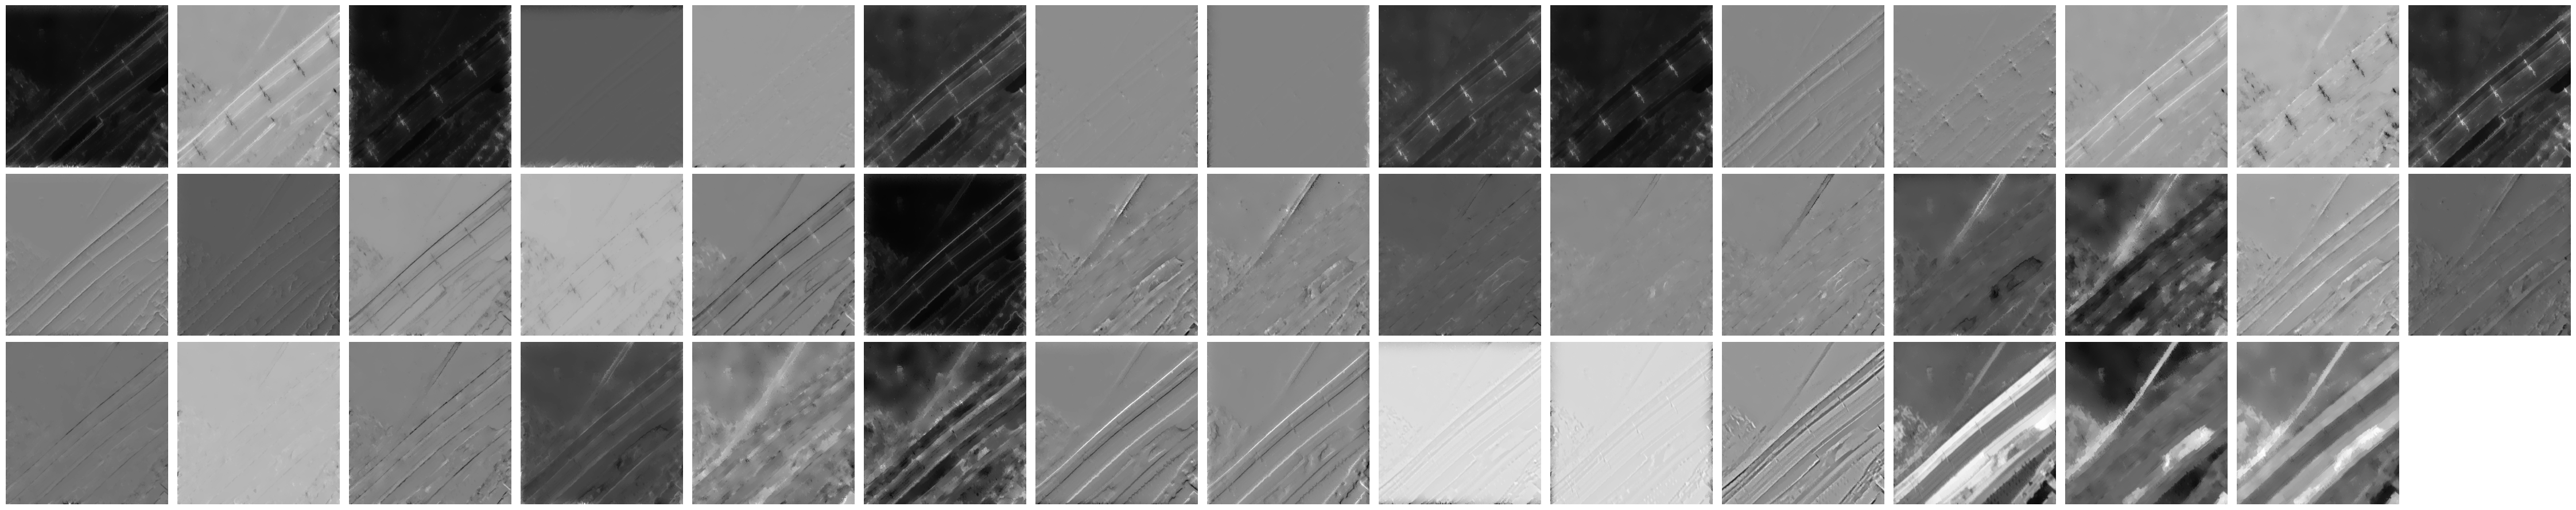

In [63]:
D = S_dubf.shape[-1]

N = 15  # Number of columns for plotting
plt.figure(figsize=(N * 3, (D // N + 1) * 3))
for i in range(D):
    plt.subplot(D // N + 1, N, i + 1)
    plt.imshow(S_dubf[:,:,i], cmap='gray')
    plt.axis('off')
plt.tight_layout()

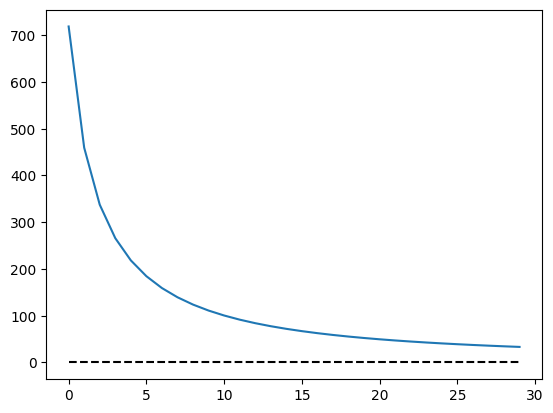

In [64]:
plt.plot(error)
plt.plot(np.arange(len(error)), np.zeros_like(error), 'k--')

In [17]:
S_dubf_ = sar_despeckling._step2_filter_texture_descriptor(**params_dubf)

error_on_dubf = jnp.abs(S_dubf - S_dubf_).mean()
print(f"Error on DUBF: {error_on_dubf:.16f}")

INFO:root:Filtering texture descriptor with DUBF...
DUBF Iterations: 100%|██████████| 30/30 [00:48<00:00,  1.61s/it]
INFO:root:Texture descriptor filtering completed in 48.20 seconds.


Error on DUBF: 0.0000000000000000


### Despeckle

In [18]:
# i, j = 150, 150  # width, height -> x, y
# sigma_d = 3

# similarity_map = compute_similarity_map(S_dubf[j, i, :], S_dubf, sigma_d=sigma_d)  # y, x
# print(similarity_map.shape)

# plt.figure(figsize=(12, 4))
# plt.subplot(1, 3, 1)
# plt.imshow(opt)
# plt.scatter(i, j, c='r', s=100, marker='x')  # x, y
# plt.axis('off')
# plt.subplot(1, 3, 2)
# plt.imshow(sar, cmap='gray')
# plt.scatter(i, j, c='r', s=100, marker='x')  # x, y
# plt.axis('off')
# plt.subplot(1, 3, 3)
# plt.imshow(similarity_map, cmap='jet')
# plt.scatter(i, j, c='r', s=100, marker='x')  # x, y
# plt.axis('off')
# plt.tight_layout()

In [72]:
params_despeckling = {
    "sar": sar,
    "descriptor": S_dubf,
    "sigma_distance": 1.5,
    "radius": 75,
    "n_blocks": 100
}

In [68]:
def despeckle(sar: jnp.ndarray, descriptor: jnp.ndarray, sigma_distance: float, radius: float, n_blocks: int = 10) -> jnp.ndarray:
    H, W, _ = descriptor.shape
    kernel_size = 2 * radius + 1  # k = 2 * r + 1

    # Pad the input arrays to handle borders
    pad_width = ((radius, radius), (radius, radius), (0, 0))
    S_pad = jnp.pad(descriptor.copy(), pad_width, mode='reflect')  # (H+2*r, W+2*r, D)
    sar_pad = jnp.pad(sar.copy(), pad_width, mode='reflect')  # (H+2*r, W+2*r, 1)

    # Precompute Gaussian weights
    Gs = gaussian_kernel_2d(radius).reshape(1, 1, kernel_size, kernel_size, 1)  # (1, 1, k, k, 1)

    # Compute start and end indices for memory efficiency
    start_indices, end_indices = compute_indices_from_n_blocks(n_blocks, H, W, padding=radius)

    sar_filtered = jnp.zeros_like(sar_pad)  # Initialize update tensor
    std = jnp.zeros_like(sar_pad) 

    # Iterate over the blocks
    progress_bar = tqdm(total=len(start_indices), desc="Despeckling", unit="block")
    for start_index, end_index in zip(start_indices, end_indices):
        # Extract windows (patches) for all spatial locations
        S_patches = extract_patches(S_pad, kernel_size, start_index, end_index)   # (H', W', k, k, D)
        sar_patches = extract_patches(sar_pad, kernel_size, start_index, end_index)  # (H', W', k, k, 1)

        S_centers = S_patches[..., radius, radius, :][..., None, None, :]  # Centers are located at (radius, radius)
        diff = S_patches - S_centers # (H', W', k, k, D)
        distsq = jnp.sum((diff)**2, axis=-1) 
        similarity_map = jnp.exp(-distsq / (2 * sigma_distance ** 2))

        Gd = similarity_map[..., None]
        w = Gd 
        Z = 1 / w.sum(axis=(-3, -2))  # (H', W')

        update_block = (w * sar_patches).sum(axis=(-3, -2))  # (H', W', 1)
        update_block = update_block * Z # Normalize by the sum of weights

        update_std = (w * (sar_patches - update_block[..., None, None, :])**2).sum(axis=(-3, -2))
        update_std = jnp.sqrt(update_std * Z)

        # Update only the current block
        sar_filtered = jax.lax.dynamic_update_slice(sar_filtered, update_block, start_index + (0,))  
        std = jax.lax.dynamic_update_slice(std, update_std, start_index + (0,))
        progress_bar.update(1)
    progress_bar.close()
    
    # Remove padding
    return sar_filtered[radius:-radius, radius:-radius, :], std[radius:-radius, radius:-radius, :]  

In [69]:
print(S.shape, sar.shape)

(500, 500, 44) (500, 500, 1)


In [73]:
time_start = time.time()
sar_filtered, std = despeckle(**params_despeckling)
time_end = time.time()
print(f"{time_end - time_start:.4f} seconds")

Despeckling:   0%|          | 0/10000 [00:00<?, ?block/s]

Despeckling: 100%|██████████| 10000/10000 [01:27<00:00, 114.27block/s]

87.5341 seconds


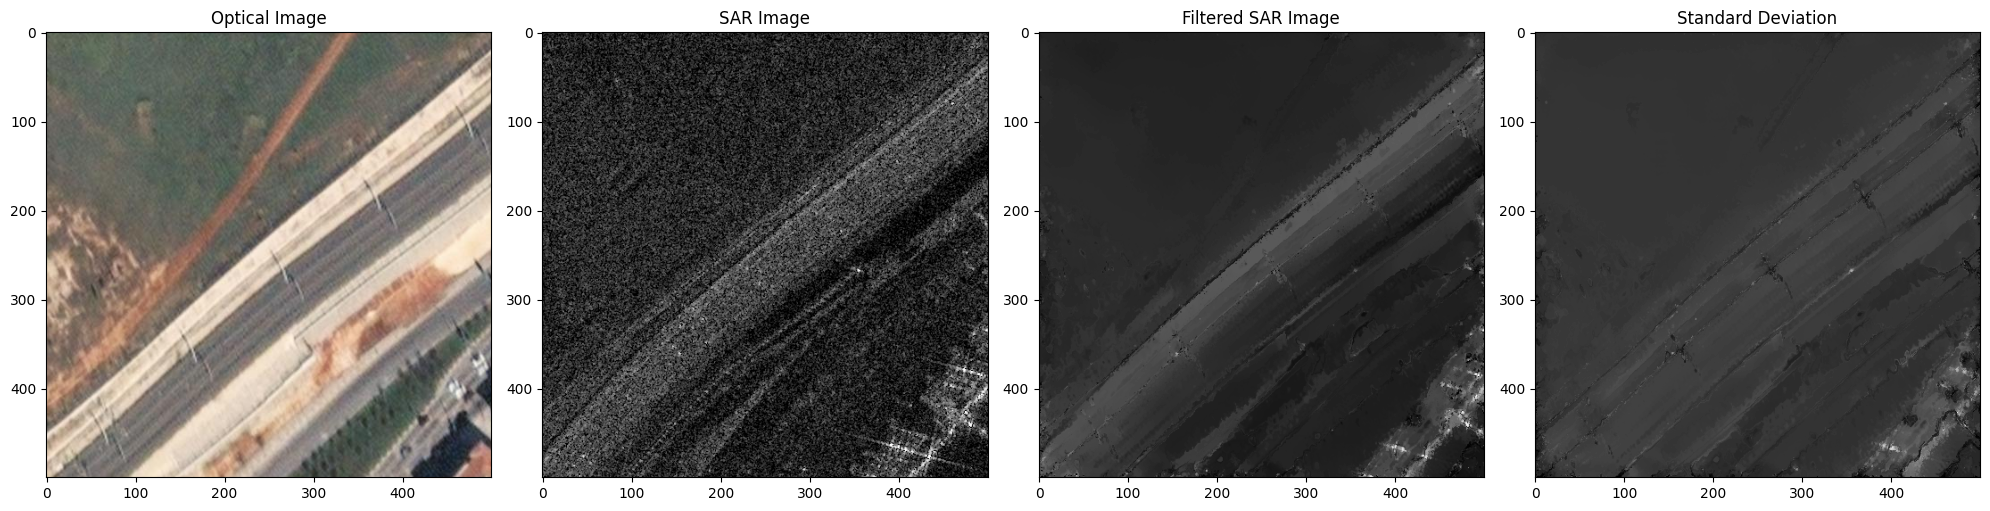

In [74]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.imshow(opt)
plt.title('Optical Image')
plt.subplot(1, 4, 2)
plt.imshow(sar, cmap='gray')
plt.title('SAR Image')
plt.subplot(1, 4, 3)
plt.imshow(sar_filtered, cmap='gray')
plt.title('Filtered SAR Image')
plt.subplot(1, 4, 4)
plt.imshow(std, cmap='gray')
plt.title('Standard Deviation')
plt.tight_layout()

In [75]:
sar_filtered_ = sar_despeckling._step3_despeckle(**params_despeckling)

error_on_despeckling = jnp.abs(sar_filtered - sar_filtered_).mean()
print(f"Error on despeckling: {error_on_despeckling:.16f}")

INFO:root:Despeckling SAR image...
Despeckling: 100%|██████████| 10000/10000 [01:06<00:00, 150.12block/s]
INFO:root:Despeckling completed in 66.64 seconds.


Error on despeckling: 0.0000000000000000


### Test global

In [25]:
# sar_filtered = sar_despeckling.run(sar, 
#                                    opt_rgb,
#                                    radius_descriptor=21,
#                                    sigma_s=5,
#                                    sigma_l_opt=0.1,
#                                    sigma_l_sar=0.1,
#                                    alpha_ubf=1.0,
#                                    n_iter=30,
#                                    sigma_d=1.5,
#                                    radius_despeckling=50,
#                                    n_blocks=10)

In [26]:
# plt.figure(figsize=(15, 5))
# plt.subplot(1, 3, 1)
# plt.imshow(opt)
# plt.title('Optical Image')
# plt.subplot(1, 3, 2)
# plt.imshow(sar, cmap='gray')
# plt.title('SAR Image')
# plt.subplot(1, 3, 3)
# plt.imshow(sar_filtered, cmap='gray')
# plt.title('Filtered SAR Image')
# plt.tight_layout()

In [27]:
# plt.plot(sar_despeckling.error)